# 02-Market analysis

In this notebook, we will take a look at the cleaned data and give the reader insight towards the airbnb market in Austin, the average income, good investment opportunities, and factors that are important to consider during investment. 

In [1]:
# import
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#plot city map
import geopandas as gpd 
import folium

In [2]:
# read the data 
df = pd.read_csv('./../data/austin_listings_clean.csv')
df.head(5)

,bedrooms,beds,bath,zipcode,host_is_superhost,review_scores_rating,time_quarter,has_pool,is_petfriendly,has_workspace,has_freeparking,has_gym,home_price_aprx,price,occupancy_rate
0,1,2,1.0,78702,1,4.84,Q4,0,0,0,0,0,359197.038337,101.000000,0.700000
1,0,1,1.0,78704,0,4.97,Q4,0,0,1,0,0,327170.306567,91.666667,0.700000
2,1,2,1.0,78704,1,4.97,Q4,0,0,1,1,0,327170.306567,159.000000,0.584160
3,1,1,1.0,78741,0,4.56,Q4,0,1,0,0,0,190189.768301,48.000000,0.100850
4,2,2,2.0,78702,1,5.00,Q4,0,0,1,0,0,470342.688268,123.000000,0.216998


We will create a new column for quarterly income for each listing. 

In [3]:
df['quarterly_income'] = df['price'] * df['occupancy_rate'] * 90


## Average quarterly income

We will start our investigations by looking at the quarterly incomes. 

In [4]:
df['quarterly_income'].describe()

count     37341.000000
mean       4647.285812
std        6702.261757
min          11.730970
25%         720.858164
50%        2378.041237
75%        6011.947864
max      113400.000000
Name: quarterly_income, dtype: float64

The average quarterly income for the city of Austin is 4600 ($1500/month). 

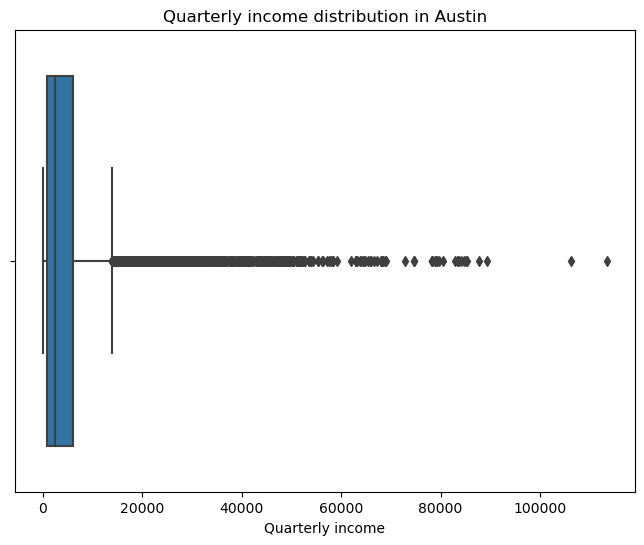

In [5]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='quarterly_income')

plt.xlabel('Quarterly income')
#plt.ylabel('Occupancy rate')
plt.title('Quarterly income distribution in Austin');

We can see the data is very right skewed and there are some cases with very high estimated quarterly income (those numbers are quite unlikely to have). Let us set a cutoff to take a look at the quarterly income less than $20k.

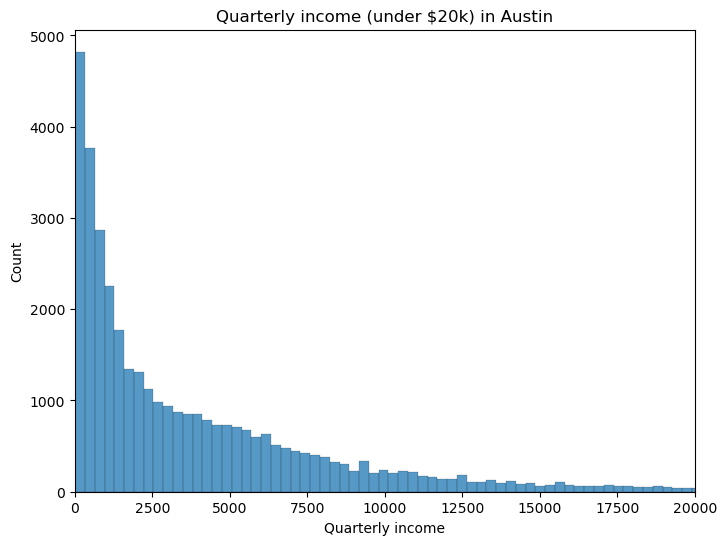

In [6]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='quarterly_income')

plt.xlabel('Quarterly income')
plt.xlim((0, 20000))
#plt.ylabel('Occupancy rate')
plt.title('Quarterly income (under $20k) in Austin');

We see that a big portion of the listings report a quarterly income of less than 10000 with a median income of $2400. Let's see how quarterly income is distributed at different times of the year.

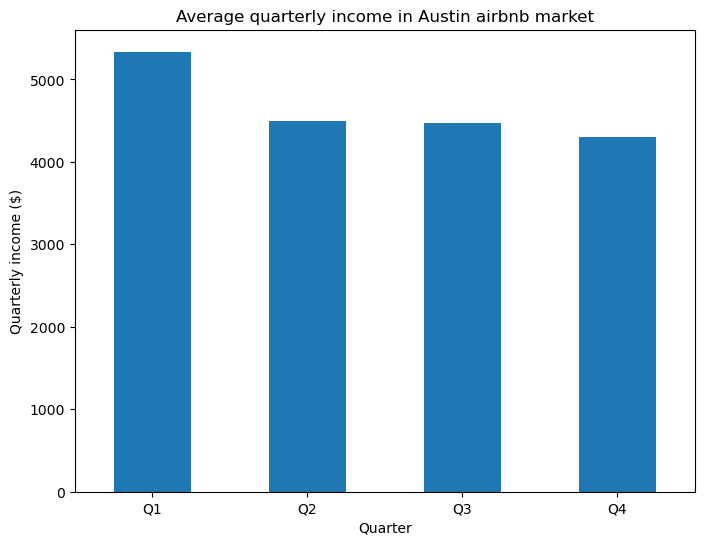

In [7]:
plt.figure(figsize=(8,6))
df.groupby(by='time_quarter')['quarterly_income'].mean().plot.bar()

plt.xlabel('Quarter')
plt.xticks(rotation=0)
plt.ylabel('Quarterly income ($)')
plt.title('Average quarterly income in Austin airbnb market');


We can see the average income is the highest at the first quarter of each yaer due to higher demand and travel rate during the holiday season. 

## Quarterly income at different neighborhoods

In this section, we will take a look at the the average quarterly income for different neighborhoods in Austin. 

C:\Users\masou\AppData\Local\Temp\ipykernel_14796\2576642862.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('zipcode').mean()['quarterly_income'].sort_values(ascending=False).plot.bar()


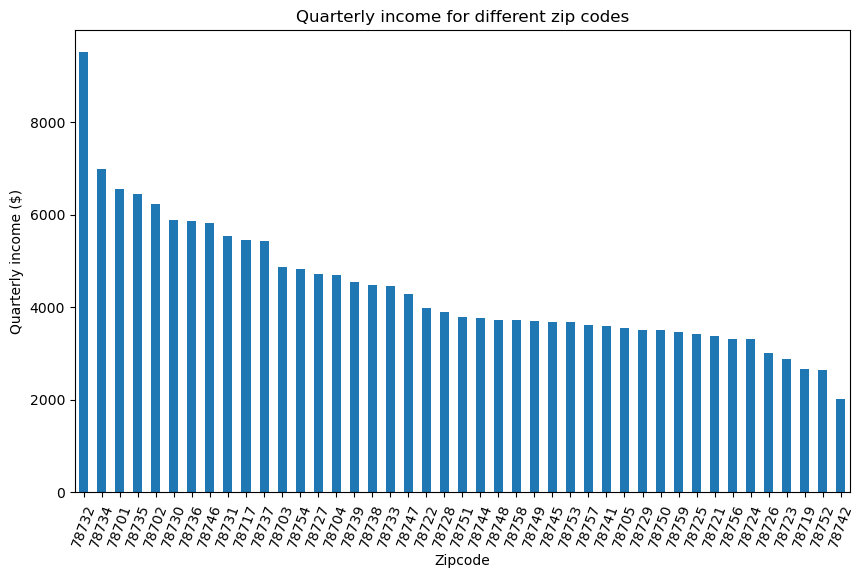

In [8]:
plt.figure(figsize=(10,6))
df.groupby('zipcode').mean()['quarterly_income'].sort_values(ascending=False).plot.bar()

plt.xlabel('Zipcode')
plt.xticks(rotation=70)
plt.ylabel('Quarterly income ($)')
plt.title('Quarterly income for different zip codes');


From the graph, we can see the zip code like 78732 earns way more than the other zip codes. However, this zipcode has just 180 listings for the entire 2023. To get a more realistic idea of what neighborhoods earn higher, let us just filter the zip codes that have at least 500 listings during the year. 

C:\Users\masou\AppData\Local\Temp\ipykernel_14796\2917036684.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df['zipcode'].isin(over500_zips)].groupby('zipcode').mean()['quarterly_income'].sort_values(ascending=False).plot.bar()


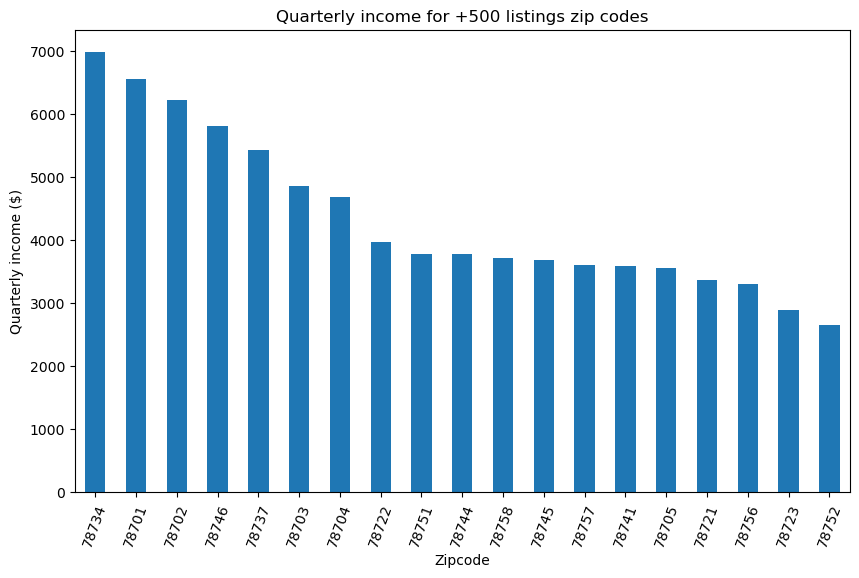

In [9]:
over500_zips = [zipcode for zipcode, num in df['zipcode'].value_counts().items() if num > 500]
plt.figure(figsize=(10,6))
df[df['zipcode'].isin(over500_zips)].groupby('zipcode').mean()['quarterly_income'].sort_values(ascending=False).plot.bar()

plt.xlabel('Zipcode')
plt.xticks(rotation=70)
plt.ylabel('Quarterly income ($)')
plt.title('Quarterly income for +500 listings zip codes');

Now, let us take a look at the neighborhoods to see where each of these zipcodes are located. 

In [10]:
zips_avr_income = df[df['zipcode'].isin(over500_zips)].groupby('zipcode').mean()[['quarterly_income']]
zips_avr_income['zipcode'] = zips_avr_income.index

C:\Users\masou\AppData\Local\Temp\ipykernel_14796\3265620201.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  zips_avr_income = df[df['zipcode'].isin(over500_zips)].groupby('zipcode').mean()[['quarterly_income']]


In [11]:
# create folium object and set the default coordinate and zoom
m = folium.Map(location=[30.26, -97.74], zoom_start=11)
# read the geojson data
city = gpd.read_file('./../data/neighbourhoods.geojson')
folium.Choropleth(
    geo_data=city,
    # create the data that should be used as an overlay
    data=zips_avr_income,
    # more on how to plot https://python-visualization.github.io/folium/latest/user_guide/geojson/choropleth.html
    columns=["zipcode", "quarterly_income"],
    # by looking inside the json file, see where zipcode data is located and address it here
    key_on="feature.properties.neighbourhood",
    # set the colors OrangeRed
    # more info on colors https://python-visualization.github.io/folium/latest/advanced_guide/colormaps.html 
    # https://python-visualization.github.io/folium/latest/user_guide/geojson/geojson.html
    fill_color="OrRd",
    color= "black",
    fill_opacity=0.4,
    line_opacity= 0.9,
    line_weight=1,
    legend_name="Quarterly income ($)",
).add_to(m)
m

Looking at the map above, we can say that the listings around the downtown area show the highest average income. In addition to that, the houses near lake Travis area seem to have a high income (those should be mostly bigger places that are used by groups). 

## Best retrun for $100k of investment

Now that we know what areas would result in the highest income, let us take a look at the problem from another perspective. Areas like downtown would result in higher income but the home price there is high as well. So, as an investor, you might be more interested in seeing how much return you would get from $100k of investment. To do that, we will create a new column that divides the income into 100k's of investment based on the home price data we have extracted from Zillow.com. Please note that we are considering zip codes with more than 500 

In [12]:
df['retrun_per100k'] = df['quarterly_income']/df['home_price_aprx'] * 100_000

C:\Users\masou\AppData\Local\Temp\ipykernel_14796\4030941766.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df['zipcode'].isin(over500_zips)].groupby('zipcode').mean()['retrun_per100k'].sort_values(ascending=False).plot.bar()


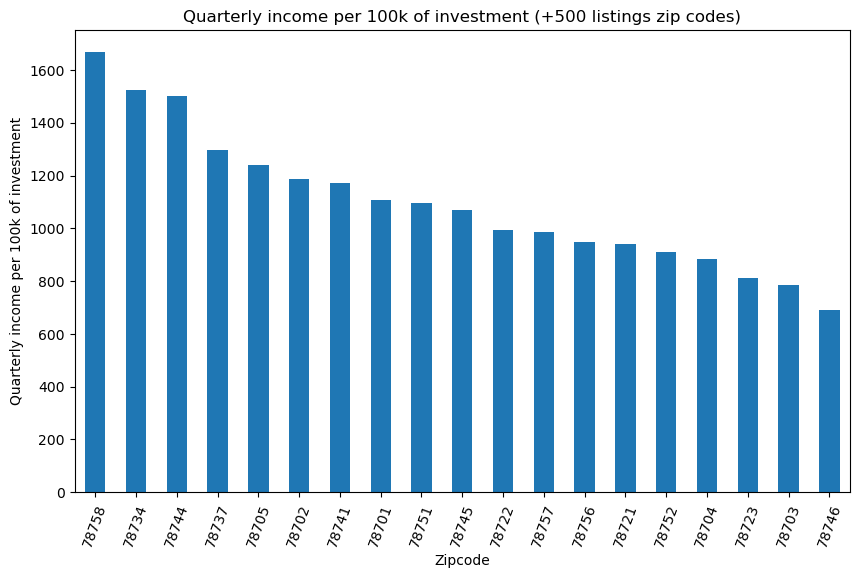

In [13]:
plt.figure(figsize=(10,6))
df[df['zipcode'].isin(over500_zips)].groupby('zipcode').mean()['retrun_per100k'].sort_values(ascending=False).plot.bar()

plt.xlabel('Zipcode')
plt.xticks(rotation=70)
plt.ylabel('Quarterly income per 100k of investment')
plt.title('Quarterly income per 100k of investment (+500 listings zip codes)');

In [14]:
zips_inv = df[df['zipcode'].isin(over500_zips)].groupby('zipcode').mean()[['retrun_per100k']]
zips_inv['zipcode'] = zips_avr_income.index
# create folium object and set the default coordinate and zoom
m = folium.Map(location=[30.26, -97.74], zoom_start=11)
# read the geojson data
city = gpd.read_file('./../data/neighbourhoods.geojson')
folium.Choropleth(
    geo_data=city,
    # create the data that should be used as an overlay
    data=zips_inv,
    # more on how to plot https://python-visualization.github.io/folium/latest/user_guide/geojson/choropleth.html
    columns=["zipcode", "retrun_per100k"],
    # by looking inside the json file, see where zipcode data is located and address it here
    key_on="feature.properties.neighbourhood",
    # set the colors OrangeRed
    # more info on colors https://python-visualization.github.io/folium/latest/advanced_guide/colormaps.html 
    # https://python-visualization.github.io/folium/latest/user_guide/geojson/geojson.html
    fill_color="OrRd",
    color= "black",
    fill_opacity=0.4,
    line_opacity= 0.9,
    line_weight=1,
    legend_name="Income ($) per 100k investment",
).add_to(m)
m

C:\Users\masou\AppData\Local\Temp\ipykernel_14796\3443815707.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  zips_inv = df[df['zipcode'].isin(over500_zips)].groupby('zipcode').mean()[['retrun_per100k']]


We can see that for new investors who are looking for invetment opportunities in Austin, the income per 100k of investment is more for neighborhoods away from the downtown area. That is because the high home price in the central areas makes it less favorable for investors as they need to invest more and the rate of return (income from airbnb) does not go as high as the home price.   

## Quarterly income vs. number of bedrooms/baths

In this section we will see how average income changes for different number of bedrooms and bathrooms. 

C:\Users\masou\AppData\Local\Temp\ipykernel_14796\3296731064.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('bedrooms').mean()['quarterly_income'].plot.bar()


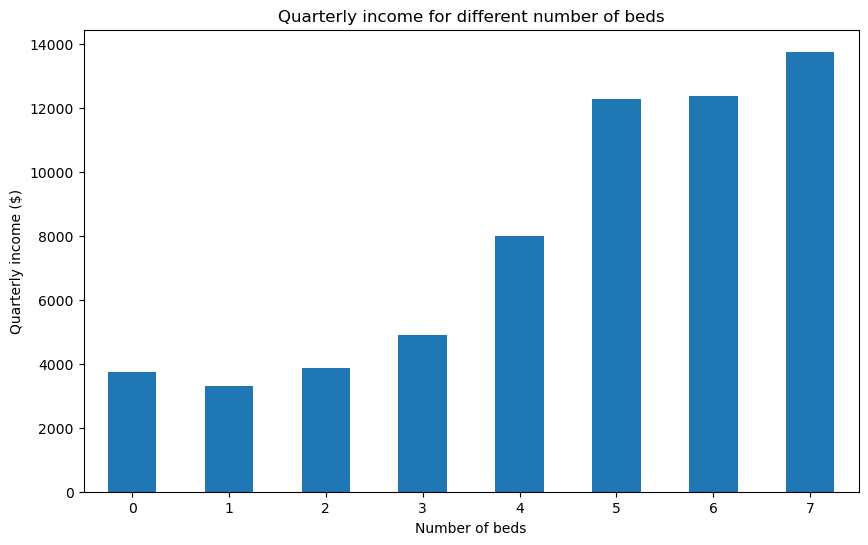

In [15]:

plt.figure(figsize=(10,6))
df.groupby('bedrooms').mean()['quarterly_income'].plot.bar()

plt.xlabel('Number of beds')
plt.xticks(rotation=0)
plt.ylabel('Quarterly income ($)')
plt.title('Quarterly income for different number of beds');

Looking at this graph, we can say lisitngs with 4 bedrooms or more earn 50% more than smaller houses. Next graph shows the average income vs. number of baths. Please note that since the number listings with baths less than 1 and more than 6 was quite limited, we filtered the data to show just the ones between 1-5 beds. 

C:\Users\masou\AppData\Local\Temp\ipykernel_14796\4149349170.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[(df['bath'] <= 5) & (df['bath'] > 0.5)].groupby('bath').mean()['quarterly_income'].plot.bar()


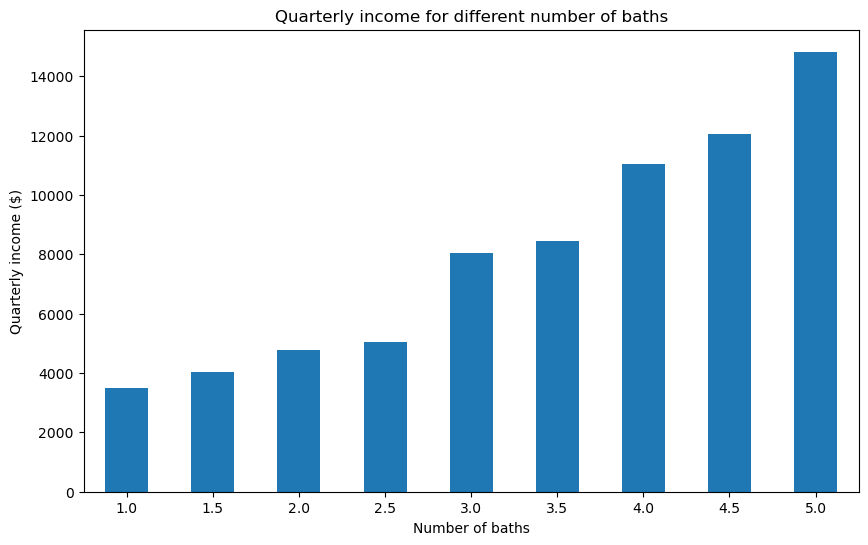

In [16]:

plt.figure(figsize=(10,6))
df[(df['bath'] <= 5) & (df['bath'] > 0.5)].groupby('bath').mean()['quarterly_income'].plot.bar()

plt.xlabel('Number of baths')
plt.xticks(rotation=0)
plt.ylabel('Quarterly income ($)')
plt.title('Quarterly income for different number of baths');

Similar to the number of beds, we can see as the number of baths increases, the average income increases. There is a sharp jump for houses with 3+ baths. 

## Effect of other factors on income

We will now take a look at the remaining features to see if there is any feature that has a significant impact on our income. 

In [76]:
features_to_check = ['host_is_superhost', 'has_pool', 'is_petfriendly', 
                     'has_workspace', 'has_freeparking', 'has_gym']
for i in features_to_check:
    print(f'=======> {i}')
    print(df.groupby(i).mean(numeric_only=True)['quarterly_income'])

=======> host_is_superhost
host_is_superhost
0    3735.865816
1    5721.938065
Name: quarterly_income, dtype: float64
=======> has_pool
has_pool
0    4361.492091
1    5301.989431
Name: quarterly_income, dtype: float64
=======> is_petfriendly
is_petfriendly
0    4570.932686
1    4780.881293
Name: quarterly_income, dtype: float64
=======> has_workspace
has_workspace
0    4912.873909
1    4494.544928
Name: quarterly_income, dtype: float64
=======> has_freeparking
has_freeparking
0    5109.912961
1    4532.077786
Name: quarterly_income, dtype: float64
=======> has_gym
has_gym
0    4679.324461
1    4458.186716
Name: quarterly_income, dtype: float64


C:\Users\masou\AppData\Local\Temp\ipykernel_14796\1478337877.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('host_is_superhost').mean()['quarterly_income'].plot.bar()


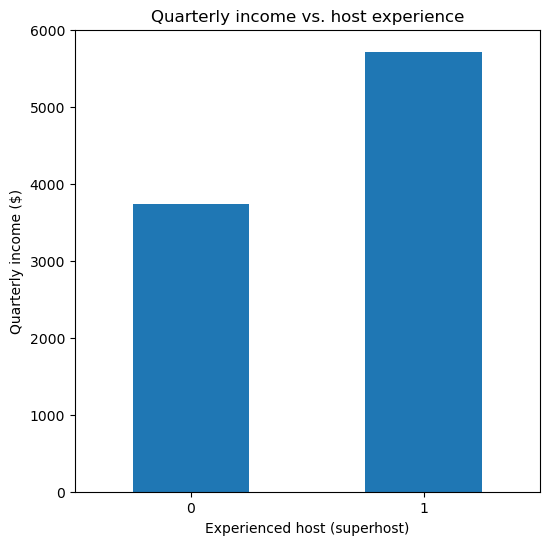

In [22]:

plt.figure(figsize=(6,6))
df.groupby('host_is_superhost').mean()['quarterly_income'].plot.bar()

plt.xlabel('Experienced host (superhost)')
plt.xticks(rotation=0)
plt.ylabel('Quarterly income ($)')
plt.title('Quarterly income vs. host experience');

C:\Users\masou\AppData\Local\Temp\ipykernel_14796\4077210608.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('has_pool').mean()['quarterly_income'].plot.bar()


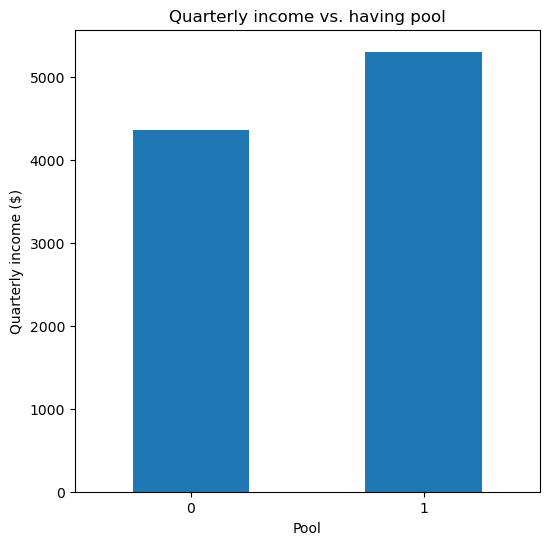

In [23]:

plt.figure(figsize=(6,6))
df.groupby('has_pool').mean()['quarterly_income'].plot.bar()

plt.xlabel('Pool')
plt.xticks(rotation=0)
plt.ylabel('Quarterly income ($)')
plt.title('Quarterly income vs. having pool');

An important observation here is that being a superhost has significant effect on the income (probably by having a higher occupancy rate). The other observation is that houses that have pool earn more than the ones without pool. However, this could be just the effect of houses with pools are bigger (with more bedrooms) and because of that, the income is more. To see what the effect of pool itself, let us first groupby listings by the number of beds and then by presence of pool. 

In [80]:
df.groupby(['bedrooms', 'has_pool']).mean(numeric_only=True)['quarterly_income']

bedrooms  has_pool
0         0            3716.639591
          1            3749.538725
1         0            3257.126476
          1            3355.109657
2         0            3651.790348
          1            4356.627641
3         0            4589.800092
          1            6431.109314
4         0            7118.251365
          1            9909.525794
5         0           11385.728708
          1           13336.475974
6         0            9831.083503
          1           16815.691448
7         0           16474.398027
          1           12278.609575
Name: quarterly_income, dtype: float64

From these results, we can say having pool does not have effect on smaller houses (0 and 1 beds), however, for homes with two or more bedrooms, having a pool will likely increase the average income. 

## Key takeaways:
- The average quarterly income from airbnb in the city of Austin is $4600.
- First quarter of the year usualy generates more income than other times.
- Highest income airbnbs are located around the downtown or Lake Travis area. 
- Houses with 4+ bedrooms show a jump in the income, compared to smaller properties. 
- Being a superhost significantly impacts the yearly income of listings. 